In [10]:
import numpy as np
all_h_mol = "/share/project/sharefs-skfeng/pre-training-via-denoising/h_mol_lst.npy"
MOL_LST = np.load(all_h_mol, allow_pickle=True)

: 

: 

In [64]:
from rdkit import Chem
import py3Dmol
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
import copy

In [62]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    # viewer.addPropertyLabels("atom","","")

    # for i, at in enumerate(mol):
    #     default = {"stick": {'color': 'black'}}
    #     viewer.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [75]:
mol = MOL_LST[1233167]
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [76]:
equi_mol = copy.copy(mol)
props = AllChem.MMFFGetMoleculeProperties(equi_mol)
ff2 = AllChem.MMFFGetMoleculeForceField(equi_mol, props)
print(ff2.CalcEnergy())

15.842927724652984


In [77]:
from torsion_utils import get_torsions, GetDihedral
no_h_mol = Chem.RemoveHs(equi_mol)
rotable_bonds = get_torsions([no_h_mol])
org_angle = []
for rot_bond in rotable_bonds:
    org_angle.append(GetDihedral(equi_mol.GetConformer(), rot_bond))
print(rotable_bonds)
print(org_angle)

[(4, 9, 8, 3)]
[-156.6203095672457]


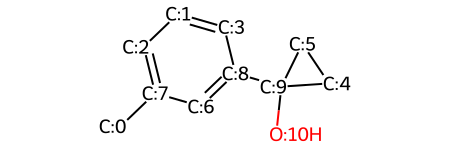

In [78]:
def show_atom_number(mol, label):
    # mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp(label, str(i))
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    return mol
show_atom_number(equi_mol, 'molAtomMapNumber')

In [79]:
import altair as alt
import copy
import pandas as pd

In [83]:
m2=copy.deepcopy(equi_mol)
m3 = copy.deepcopy(m2)
mp = AllChem.MMFFGetMoleculeProperties(m3)
# mp.SetMMFFOopTerm(False)    # That's the critical bit here - switch off out of plane terms for MMFF
ffm = AllChem.MMFFGetMoleculeForceField(m3, mp)
energy=[]
confid=0
angles=range(0, 370, 5)
for angle in angles:
    confid+=1
    ff2 = AllChem.MMFFGetMoleculeForceField(m3, mp)
    ff2.MMFFAddTorsionConstraint(4, 9, 8, 3, False, angle - .1, angle + .1, 5.0)
    ff2.MMFFAddTorsionConstraint(4, 9, 8, 3, False, angle - .1, angle + .1, 5.0)
    ff2.Minimize()
    energy.append(ff2.CalcEnergy())
    xyz=ff2.Positions()
    new_conf = Chem.Conformer(equi_mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        new_conf.SetAtomPosition(i, (m3.GetConformer(-1).GetAtomPosition(i)))
    new_conf.SetId(confid)
    m2.AddConformer(new_conf)

dfrdkit = pd.DataFrame({'angle':angles, 'energy':energy})
alt.Chart(dfrdkit).mark_line(point=True,interpolate="natural").encode(
    alt.X('angle:Q',
        scale=alt.Scale(domain=[0,360,350])
    ),
    alt.Y('energy:Q',
        scale=alt.Scale(zero=False)
    )
).interactive()

alt.Chart(...)

In [84]:
from ipywidgets import interact, interactive, fixed
import py3Dmol
patt = Chem.MolFromSmarts('c1ccccc1');patt
match = m2.GetSubstructMatch(patt)
AllChem.AlignMolConformers(equi_mol,atomIds=match)
def drawit(m, p, confId):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    return p.show()
viewer = py3Dmol.view(width=500, height=500)
mb = Chem.MolToMolBlock(m2, confId=0)
viewer.addModel(mb,'sdf')
viewer.setStyle({'stick':{}})
viewer.zoomTo()
conformerIds=[conf.GetId() for conf in m2.GetConformers()]
interact(drawit, m=fixed(m2), p=fixed(viewer), confId=(0, m2.GetNumConformers() - 1))

interactive(children=(IntSlider(value=37, description='confId', max=74), Output()), _dom_classes=('widget-inte…

<function __main__.drawit(m, p, confId)>

In [85]:
print(conformerIds)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]


In [86]:
conformers=[conf for conf in m2.GetConformers()]

In [87]:
conformers[0].GetPositions()

array([[ 1.43069994, -0.081     ,  1.18359995],
       [ 4.17539978,  0.92970002, -1.26390004],
       [ 3.01160002,  0.96420002, -0.4989    ],
       [ 5.04759979, -0.1557    , -1.17840004],
       [ 5.26079988, -3.75710011,  0.22139999],
       [ 6.15670013, -2.91969991,  1.10140002],
       [ 3.58730006, -1.17439997,  0.44319999],
       [ 2.7039001 , -0.0928    ,  0.368     ],
       [ 4.76130009, -1.22819996, -0.32350001],
       [ 5.71649981, -2.38490009, -0.2384    ],
       [ 6.75509977, -2.37669992, -1.19280005],
       [ 1.11000597,  0.94149411,  1.40979934],
       [ 1.55573785, -0.61336607,  2.13268924],
       [ 0.60682845, -0.56783813,  0.64446598],
       [ 4.41229343,  1.75757945, -1.92758906],
       [ 2.33852816,  1.81562304, -0.56935304],
       [ 5.96457195, -0.17040586, -1.7573483 ],
       [ 4.22272301, -3.90357351,  0.5060606 ],
       [ 5.71557188, -4.60030079, -0.29077813],
       [ 7.20043039, -3.20793509,  1.18267107],
       [ 5.73427486, -2.45779777,  1.989

In [90]:
energy

[12.556833618845499,
 12.82956432350974,
 13.072486095938025,
 13.276819637886966,
 13.451375760046483,
 13.60886971367497,
 13.762188008549039,
 13.920574005093865,
 14.086534575324103,
 14.253997777694659,
 14.408137787929508,
 14.527178075940263,
 14.586103366993504,
 14.558437352184685,
 14.428059824091353,
 14.185191075315373,
 13.821714247597154,
 11.594844472502384,
 11.232511418087345,
 10.889380298153899,
 10.58137716413924,
 10.321769440914014,
 10.120579439527937,
 9.984563078775256,
 9.917461076897187,
 9.917909647402393,
 9.910242033396672,
 9.948290395657644,
 10.056326123483014,
 10.233025535221428,
 10.474282337249196,
 10.772852439587144,
 11.117650292484178,
 11.49328028296729,
 11.880267587895757,
 12.256588558065648,
 12.601059620004213,
 12.898254715203862,
 13.142803463162755,
 13.340199362910049,
 13.50356260629938,
 13.648646240666272,
 13.789469572897973,
 13.935399363985484,
 14.089457981074709,
 14.24744320718602,
 14.397633893248909,
 14.521149429309933,
 14

In [89]:
def find_minima_id(energy_lst, window_size=5):
    idx = window_size // 2
    minima_idx = []
    e_len = len(energy_lst)
    while idx + 2 < e_len:
        if (energy_lst[idx - 2] > energy_lst[idx - 1]) and (energy_lst[idx - 1] > energy_lst[idx]) \
           and (energy_lst[idx] < energy_lst[idx + 1]) and (energy_lst[idx + 1] < energy_lst[idx + 2]):
            minima_idx.append(idx)
        idx += 1
    return minima_idx
print(find_minima_id(energy))

[]


In [11]:
import numpy as np
MG_MOL_LST1 = np.load('MG_MOL_LST_part_1.npy', allow_pickle=True)
MG_E = np.load('MG_E_part_1.npy', allow_pickle=True)

In [3]:
import numpy as np
MG_E = np.load('MG_E_part_1.npy', allow_pickle=True)
len(MG_E)

422325

In [26]:
cnt = 0
for ele in MG_E:
    if not len(ele):
        cnt += 1

In [27]:
cnt 

13414

In [29]:
import numpy as np
res_file = np.load("res_lst.npy")
res_file = np.array(res_file)

In [32]:
(res_file == 0).sum()

3159680

In [37]:
(res_file == -1).sum()

218925

In [38]:
(res_file == -2).sum()

1

In [39]:
res_file.shape

(3378606,)

In [45]:
empty_idx = []
check_num = [1, 2, 3]
cnt = 0
for num in check_num:
    MG_E = np.load(f'MG_E_part_{num}.npy', allow_pickle=True)
    for ele in MG_E:
        if not len(ele):
            empty_idx.append(cnt)
        cnt += 1

In [47]:
len(empty_idx)

65608

In [52]:
error_idx = []
for e_idx in empty_idx:
    if res_file[e_idx] != -1:
        error_idx.append(e_idx)

In [74]:
error_idx[-10:]

[1199869,
 1199990,
 1200876,
 1201652,
 1221980,
 1221981,
 1223006,
 1228781,
 1230707,
 1233167]

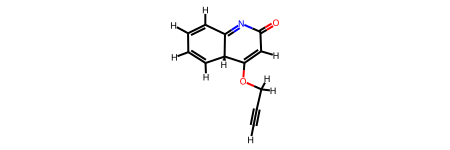

In [94]:
MG_MOL_LST1[1237]

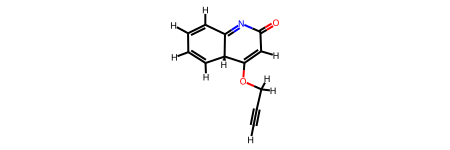

In [93]:
MOL_LST[1237]

In [99]:
len(MOL_LST)

3378606

In [26]:
import copy
mol = MG_MOL_LST1[0]
print(mol.GetNumConformers())
mol2 = copy.copy(mol)
print(mol2.GetConformer(2).GetPositions()[:3])
mol2.RemoveConformer(0)
print(mol2.GetConformer(2).GetPositions()[:3])
mol2.RemoveConformer(1)
print(mol2.GetConformer(2).GetPositions()[:3])
print(mol2.GetNumConformers())
print(mol.GetNumConformers())

3
[[ 4.04147196 -5.47710466  3.52677894]
 [ 5.82966805 -4.55546379  2.0138514 ]
 [ 3.94926381 -3.15272999  2.5708704 ]]
[[ 4.04147196 -5.47710466  3.52677894]
 [ 5.82966805 -4.55546379  2.0138514 ]
 [ 3.94926381 -3.15272999  2.5708704 ]]
[[ 4.04147196 -5.47710466  3.52677894]
 [ 5.82966805 -4.55546379  2.0138514 ]
 [ 3.94926381 -3.15272999  2.5708704 ]]
1
3


In [10]:
import torch
import torch.nn.functional as F
F.softmax(-torch.tensor(MG_E[0]))

/tmp/ipykernel_3012303/1785913399.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(-torch.tensor(MG_E[0]))


tensor([0.5088, 0.4912])

In [3]:
import torch
from torchmdnet.datasets import PCQM4MV2

raw_path = '/home/fengshikun/Backup/Denoising/data/pcq'
pcq_data = PCQM4MV2(raw_path)

In [4]:
from tqdm import tqdm
total_num = len(MOL_LST)
abnormal_lst = []
for idx in tqdm(range(total_num)):
    mol = MOL_LST[idx]
    atom_num = mol.GetNumAtoms()
    org_atom_num = pcq_data[idx].pos.shape[0]
    if atom_num != org_atom_num:
        abnormal_lst.append(idx)

100%|██████████| 3378606/3378606 [03:37<00:00, 15527.85it/s]


In [5]:
len(abnormal_lst)

32

: 

In [1]:
import numpy as np
MG_E_part_empty = np.load("MG_E_part_empty.npy", allow_pickle=True)
print(len(MG_E_part_empty))

241771


In [2]:
for ele in MG_E_part_empty:
    if len(ele):
        print('error')

In [3]:
MG_E_all = np.load("MG_All.npy", allow_pickle=True)

241771


In [4]:
print(len(MG_E_all))

3378606


In [6]:
eq_lst = []
cnt = 0
for ele in MG_E_all:
    eq_lst.append(len(ele))
    cnt += len(ele)

In [7]:
cnt

30972510

In [11]:
eq_lst = np.array(eq_lst)
eq_lst

array([ 2, 10,  9, ..., 13,  7, 12])

Freedman–Diaconis number of bins: 478


(array([2.41771e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.98900e+04,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.55138e+05, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.76514e+05, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.99117e+05, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.26233e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.31640e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.14176e+05, 0.00000e+00, 0.00000e+00, 0.00

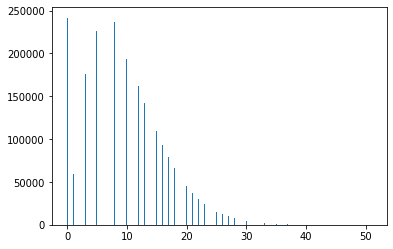

In [10]:
import matplotlib.pyplot as plt


q25, q75 = np.percentile(eq_lst, [25, 75])
bin_width = 2 * (q75 - q25) * len(eq_lst) ** (-1/3)
bins = round((eq_lst.max() - eq_lst.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(eq_lst, bins=bins)

In [14]:
MG_E_all[100]

[36.22882828235464,
 36.47819045106199,
 36.75941711852635,
 36.46367370792451,
 36.91429863937636,
 33.957310952139586,
 36.05547846566844,
 36.86085829975471,
 38.239338461158624]

In [1]:
import numpy as np
rdkit_mol_lst = '/home/fengshikun/Pretraining-Denoising/rdkit_mols_conf_lst.npy'
rdkit_mol_confs = np.load(rdkit_mol_lst, allow_pickle=True)

In [3]:
len(rdkit_mol_confs)

3378606

In [2]:
from tqdm import tqdm

no_conf_id_lst = []
# len()
conf_num_lst = []
idx = 0
for mol in tqdm(rdkit_mol_confs):
    conf_num = mol.GetNumConformers()
    if conf_num == 0:
        no_conf_id_lst.append(idx)
    idx += 1

100%|██████████| 3378606/3378606 [00:06<00:00, 518509.85it/s]


In [3]:
len(no_conf_id_lst)

48191